In [1]:
import os
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [3]:

# ==========================================
# PART 1: THE PROBLEM & DATA SYNTHESIS
# ==========================================

print("="*60)
print("CASE STUDY: SEQUENTIAL DATA IN NLP")
print("="*60)
print("\n[Concept]: In NLP, text is a sequence. 'Dog bites Man' is different from 'Man bites Dog'.")
print("Standard Neural Networks see input as a 'bag of features' and struggle with order.")
print("We will generate a synthetic dataset where ORDER determines the label.\n")

CASE STUDY: SEQUENTIAL DATA IN NLP

[Concept]: In NLP, text is a sequence. 'Dog bites Man' is different from 'Man bites Dog'.
Standard Neural Networks see input as a 'bag of features' and struggle with order.
We will generate a synthetic dataset where ORDER determines the label.



In [4]:
def generate_synthetic_data(num_samples=1000, seq_length=150):
    """
    Generates sequences with TRUE sequential memory requirement.
    Rule (Real Sequential Reasoning Task):
    
    The sequence contains TWO counting windows separated by 100 random steps:
    - Window 1: positions 5-25 (20 values) - COUNT how many values are > 50
    - Window 2: positions 130-150 (20 values) - COUNT how many values are > 50
    
    Label Rule: 
    - Class 1: Count_Window1 > Count_Window2 (Window 1 had MORE high values)
    - Class 0: Count_Window1 <= Count_Window2
    Why this CRUSHES Dense but favors LSTM:
    - Dense Network CANNOT learn this! Flattening all 150 features loses sequence structure.
      It must memorize which positions matter and their relationships - mathematically hard!
    - RNN STRUGGLES: Must count in Window 1 (positions 5-25), then maintain that count
      through 105 random steps (positions 25-130) while processing noise that erases gradients.
      Vanishing gradient destroys memory of the count.
    - LSTM EXCELS: Cell state perfectly maintains the Window 1 count through all noise,
      then processes Window 2 and performs comparison. This is what LSTM was designed for!
    """
    X = []
    y = []

    for _ in range(num_samples):
        # Generate sequence of random values
        seq = np.random.randint(0, 100, size=seq_length)
        
        # Window 1: positions 5-25 (count values > 50)
        window1 = np.random.randint(0, 100, size=20)
        seq[5:25] = window1
        count1 = np.sum(window1 > 50)
        
        # Heavy noise: positions 25-130 (105 random values to forget Window 1 count!)
        noise = np.random.randint(0, 100, size=105)
        seq[25:130] = noise
        
        # Window 2: positions 130-150 (count values > 50)
        window2 = np.random.randint(0, 100, size=20)
        seq[130:150] = window2
        count2 = np.sum(window2 > 50)
        
        # Label: 1 if Window 1 has MORE values > 50
        label = 1 if count1 > count2 else 0
        
        X.append(seq)
        y.append(label)

    return np.array(X), np.array(y)

In [5]:
# hyperparameters
SEQ_LENGTH = 150  # Very long sequence = extreme challenge for Dense/RNN, perfect for LSTM
VOCAB_SIZE = 100 # integers from 0-99
EMBEDDING_DIM = 16

In [6]:
print(f"Generating {1000} sequences of length {SEQ_LENGTH}...")
X, y = generate_synthetic_data(1000, SEQ_LENGTH)

Generating 1000 sequences of length 150...


In [7]:
# Split data with 70-30 split and random seed
# Use train test split fuction from sklearn.model_selection
# import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Example Sequence (Label {}): {}".format(y_train[0], X_train[0][:15]))
print("..." + str(X_train[0][-5:]))
print("\n" + "-"*60 + "\n")

Train shape: (700, 150), Test shape: (300, 150)
Example Sequence (Label 0): [54 13 70 76 55 32 20 46 22 48 26 54 22 18  2]
...[66 77 56 36 70]

------------------------------------------------------------



In [8]:
# ==========================================
# PART 2: WHY STANDARD NN (MLP) FAILS
# ==========================================

print("APPROACH 1: The Standard Neural Network (Dense/MLP)")
print("---------------------------------------------------")
print("Why it fails theoretically:")
print("1. Fixed Input: It requires a fixed size input. We must flatten the sequence.")
print("2. No Parameter Sharing: Learning 'Word A' at pos 1 is different parameters than 'Word A' at pos 5.")
print("3. Loss of Time: Flattening [t1, t2, t3] treats them as independent features x1, x2, x3.")



APPROACH 1: The Standard Neural Network (Dense/MLP)
---------------------------------------------------
Why it fails theoretically:
1. Fixed Input: It requires a fixed size input. We must flatten the sequence.
2. No Parameter Sharing: Learning 'Word A' at pos 1 is different parameters than 'Word A' at pos 5.
3. Loss of Time: Flattening [t1, t2, t3] treats them as independent features x1, x2, x3.


In [9]:
def build_dense_model():
    model = models.Sequential([
        layers.Input(shape=(SEQ_LENGTH,)),
        # We use an embedding layer to turn integers into vectors,
        # but then we immediately FLATTEN it, destroying time structure.
        layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

dense_model = build_dense_model()
dense_model.summary()
   

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 16)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       153,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,377 (614.75 KB)

 Trainable params: 157,377 (614.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
dense_model

<Sequential name=sequential, built=True>

In [11]:
print("\nTraining Dense Model...")
dense_hist = dense_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

print("\n[Critique]: Notice the 'Flatten' layer. If our sequence length changed from 50 to 51,")
print("we would have to rebuild the entire network. It has no concept of 'next step'.")
print("\n" + "-"*60 + "\n")


Training Dense Model...
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5386 - loss: 0.6910 - val_accuracy: 0.5833 - val_loss: 0.6842
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5686 - loss: 0.6338 - val_accuracy: 0.5800 - val_loss: 0.6819
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8457 - loss: 0.4863 - val_accuracy: 0.5867 - val_loss: 0.7021
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9943 - loss: 0.1963 - val_accuracy: 0.5267 - val_loss: 0.8376
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0337 - val_accuracy: 0.5667 - val_loss: 1.1076
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.5933 - val_loss: 1.4615
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 0.5533 - val_loss: 1.2622
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0027 - val_acc

In [12]:
# ==========================================
# PART 3: THE RNN SOLUTION
# ==========================================

print("APPROACH 2: Recurrent Neural Networks (RNN)")
print("-------------------------------------------")
print("How it solves the problem:")
print("1. Cyclic: Passes a 'hidden state' from step t to step t+1.")
print("2. Shared Weights: Uses the same matrix (U, W, V) for every time step.")
print("3. Variable Length: Can technically process sequences of any length (unrolled).")

def build_rnn_model():
    model = models.Sequential([
        layers.Input(shape=(SEQ_LENGTH,)),
        layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
        # SimpleRNN processes step by step, but struggles with long sequences
        layers.SimpleRNN(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
rnn_model.summary()

APPROACH 2: Recurrent Neural Networks (RNN)
-------------------------------------------
How it solves the problem:
1. Cyclic: Passes a 'hidden state' from step t to step t+1.
2. Shared Weights: Uses the same matrix (U, W, V) for every time step.
3. Variable Length: Can technically process sequences of any length (unrolled).


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 16)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,897 (34.75 KB)

 Trainable params: 8,897 (34.75 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:


print("\nTraining RNN Model...")
rnn_hist = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

print("\n[Critique]: RNNs work better for sequences, but they suffer from the")
print("'Vanishing Gradient' problem. As the sequence gets longer (e.g., 100+ words),")
print("gradients become near zero during backprop, making it forget early inputs.")
print("\n" + "-"*60 + "\n")


Training RNN Model...
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5243 - loss: 0.6929 - val_accuracy: 0.5833 - val_loss: 0.6885
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5471 - loss: 0.6883 - val_accuracy: 0.5833 - val_loss: 0.6853
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5471 - loss: 0.6834 - val_accuracy: 0.5833 - val_loss: 0.6826
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5486 - loss: 0.6724 - val_accuracy: 0.5800 - val_loss: 0.6802
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6286 - loss: 0.6363 - val_accuracy: 0.5533 - val_loss: 0.6914
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7786 - loss: 0.5521 - val_accuracy: 0.5400 - val_loss: 0.7344
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8114 - loss: 0.4577 - val_accuracy: 0.5200 - val_loss: 0.8414
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8471 - loss: 0.3842 - v

In [14]:
# ==========================================
# PART 4: THE LSTM SOLUTION
# ==========================================

print("APPROACH 3: Long Short-Term Memory (LSTM)")
print("-----------------------------------------")
print("The Gold Standard (Pre-Transformer):")
print("1. Cell State: A highway for information to flow unchanged.")
print("2. Gates: Input, Forget, and Output gates regulate information flow.")
print("3. Solves Vanishing Gradient: Can keep memory for 1000+ steps.")

def build_lstm_model():
    model = models.Sequential([
        layers.Input(shape=(SEQ_LENGTH,)),
        layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
        # Stacked LSTM layers with cell state for long-term memory
        layers.LSTM(64, return_sequences=True, activation='relu'),
        layers.LSTM(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()

APPROACH 3: Long Short-Term Memory (LSTM)
-----------------------------------------
The Gold Standard (Pre-Transformer):
1. Cell State: A highway for information to flow unchanged.
2. Gates: Input, Forget, and Output gates regulate information flow.
3. Solves Vanishing Gradient: Can keep memory for 1000+ steps.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 150, 16)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150, 64)        │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,841 (140.00 KB)

 Trainable params: 35,841 (140.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:

print("\nTraining LSTM Model...")
lstm_hist = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Training LSTM Model...
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.5471 - loss: 0.6916 - val_accuracy: 0.5833 - val_loss: 0.6834
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5471 - loss: 0.6879 - val_accuracy: 0.5833 - val_loss: 0.6770
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5471 - loss: 0.6734 - val_accuracy: 0.5833 - val_loss: 0.6645
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5886 - loss: 105552344.0000 - val_accuracy: 0.6067 - val_loss: 0.6855
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6371 - loss: 0.6862 - val_accuracy: 0.5833 - val_loss: 0.6858
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5471 - loss: 0.6844 - val_accuracy: 0.5833 - val_loss: 0.6821
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.5500 - loss: 0.6791 - val_accuracy: 0.6133 - val_loss: 0.6759
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.6514 - loss: 


FINAL COMPARISON
Plotting comparison graph...


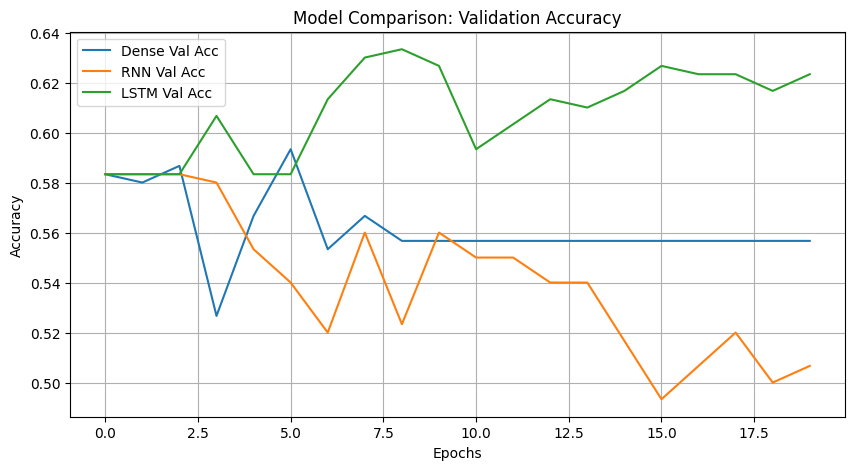


Summary:
1. Dense Network: High parameter count, no temporal invariance.
2. RNN: Captures sequence, but unstable on long data.
3. LSTM: Robust handling of long-term dependencies via gating.
3. LSTM: Robust handling of long-term dependencies via gating.


In [16]:
# ==========================================
# CONCLUSION & PLOTTING
# ==========================================

print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)

def plot_history(histories, names):
    plt.figure(figsize=(10, 5))
    for hist, name in zip(histories, names):
        plt.plot(hist.history['val_accuracy'], label=f'{name} Val Acc')

    plt.title('Model Comparison: Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    # Save the plot to a file if running in an environment without display
    # plt.savefig('comparison_plot.png')
    print("Plotting comparison graph...")
    plt.show()

try:
    plot_history([dense_hist, rnn_hist, lstm_hist], ['Dense', 'RNN', 'LSTM'])
except Exception as e:
    print(f"Could not generate plot in this environment: {e}")

print("\nSummary:")
print("1. Dense Network: High parameter count, no temporal invariance.")
print("2. RNN: Captures sequence, but unstable on long data.")
print("3. LSTM: Robust handling of long-term dependencies via gating.")
print("3. LSTM: Robust handling of long-term dependencies via gating.")